In [2]:
# Run this cell if any package is missing in Colab (usually sklearn, pandas, matplotlib exist already).
!pip install -q scikit-learn pandas matplotlib seaborn joblib


In [3]:
# Cell 1
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                             roc_curve, auc, RocCurveDisplay)
import joblib
import warnings
warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = (8,6)

# Helper: plot decision boundary for 2D features
def plot_decision_boundary(clf, X, y, title='Decision boundary', show_support=True):
    """
    clf: trained classifier (fitted)
    X: 2D numpy array shape (n_samples,2)
    y: labels (n_samples,)
    """
    x_min, x_max = X[:,0].min() - 1, X[:,0].max() + 1
    y_min, y_max = X[:,1].min() - 1, X[:,1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 400),
                         np.linspace(y_min, y_max, 400))
    grid = np.c_[xx.ravel(), yy.ravel()]
    try:
        Z = clf.predict(grid)
    except Exception:
        # if clf expects scaled features or different shape, user should pass appropriate clf
        Z = clf.decision_function(grid)
        Z = (Z > 0).astype(int)
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.2)
    scatter = plt.scatter(X[:,0], X[:,1], c=y, edgecolor='k', s=50)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(title)
    if show_support and hasattr(clf, "support_vectors_"):
        sv = clf.support_vectors_
        plt.scatter(sv[:,0], sv[:,1], s=100, facecolors='none', edgecolors='k', linewidths=1.5, label='support vectors')
        plt.legend()
    plt.show()


In [4]:
# Cell 2
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
X_all = pd.DataFrame(data.data, columns=data.feature_names)
y_all = pd.Series(data.target).map({0:0, 1:1})  # 0 = malignant, 1 = benign

print("Features shape:", X_all.shape)
print("Class distribution:\n", y_all.value_counts())
X_all.head()


Features shape: (569, 30)
Class distribution:
 1    357
0    212
Name: count, dtype: int64


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


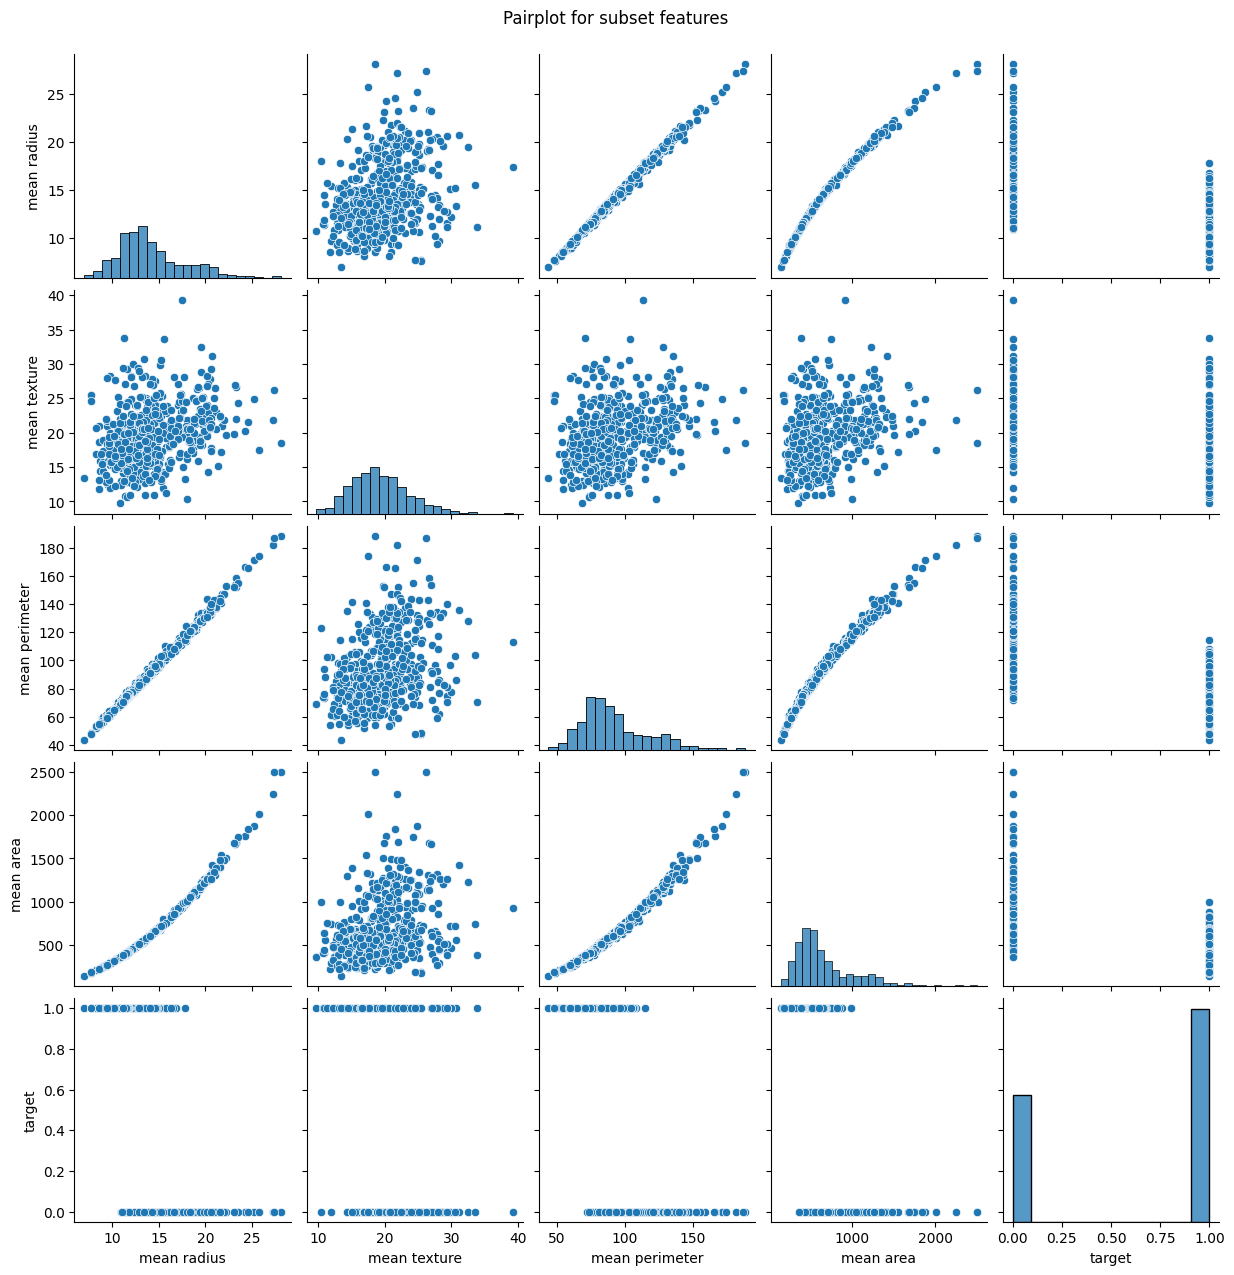

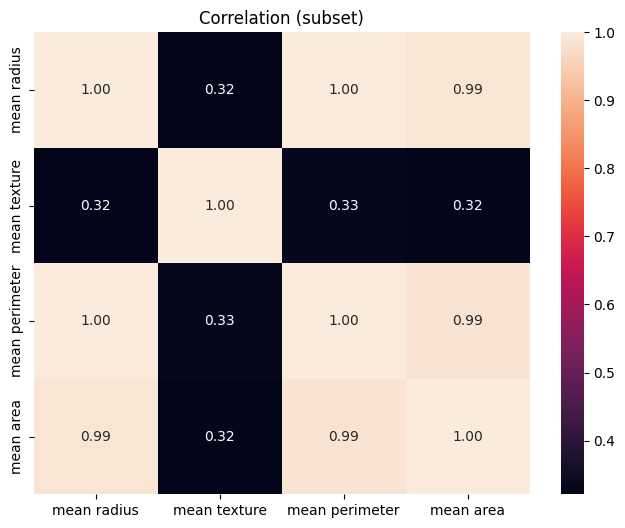

In [5]:
# Cell 3 - optional small EDA; using a subset of features to keep plot readable
subset = ['mean radius', 'mean texture', 'mean perimeter', 'mean area']
sns.pairplot(X_all[subset].assign(target=y_all))
plt.suptitle("Pairplot for subset features", y=1.02)
plt.show()

# correlation heatmap
plt.figure(figsize=(8,6))
sns.heatmap(X_all[subset].corr(), annot=True, fmt=".2f")
plt.title("Correlation (subset)")
plt.show()


In [6]:
# Cell 4
from sklearn.decomposition import PCA

# Option A: pick two interpretable features
features_2 = ['mean radius', 'mean texture']
X_2feat = X_all[features_2].values

# Option B: PCA -> 2 components (keeps most variance)
pca = PCA(n_components=2, random_state=42)
X_pca2 = pca.fit_transform(X_all)

print("Option A shape:", X_2feat.shape)
print("Option B (PCA) shape:", X_pca2.shape)
print("Explained variance by 2 PCA components:", pca.explained_variance_ratio_.sum())


Option A shape: (569, 2)
Option B (PCA) shape: (569, 2)
Explained variance by 2 PCA components: 0.9982211613741728


In [7]:
# Cell 5
# Choose which 2D input to use for visualization & simple SVM demo:
X_vis = X_pca2  # switch to X_2feat if you prefer explicit features

# For full modelling we will use full feature set (not just 2D), but for plotting we need 2D.
X_full = X_all.values
y = y_all.values

# Split for full model evaluation
X_train_full, X_test_full, y_train, y_test = train_test_split(X_full, y, test_size=0.2, random_state=42, stratify=y)

# Scale full features
scaler = StandardScaler()
X_train_full_scaled = scaler.fit_transform(X_train_full)
X_test_full_scaled = scaler.transform(X_test_full)

# For 2D visualization data: also scale
scaler2 = StandardScaler()
X_vis_scaled = scaler2.fit_transform(X_vis)
X_vis_train, X_vis_test, y_vis_train, y_vis_test = train_test_split(X_vis_scaled, y, test_size=0.2, random_state=42, stratify=y)

print("Full train shape:", X_train_full_scaled.shape)
print("Vis train shape:", X_vis_train.shape)


Full train shape: (455, 30)
Vis train shape: (455, 2)


In [8]:
# Cell 6 - baseline models
svc_linear = SVC(kernel='linear', C=1.0, probability=True, random_state=42)
svc_rbf = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=42)

svc_linear.fit(X_train_full_scaled, y_train)
svc_rbf.fit(X_train_full_scaled, y_train)

for name, model in [('Linear SVM', svc_linear), ('RBF SVM', svc_rbf)]:
    preds = model.predict(X_test_full_scaled)
    acc = accuracy_score(y_test, preds)
    print(f"{name} test accuracy: {acc:.4f}")
    print(classification_report(y_test, preds))
    print("-"*50)


Linear SVM test accuracy: 0.9737
              precision    recall  f1-score   support

           0       0.95      0.98      0.96        42
           1       0.99      0.97      0.98        72

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114

--------------------------------------------------
RBF SVM test accuracy: 0.9825
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        42
           1       0.99      0.99      0.99        72

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114

--------------------------------------------------


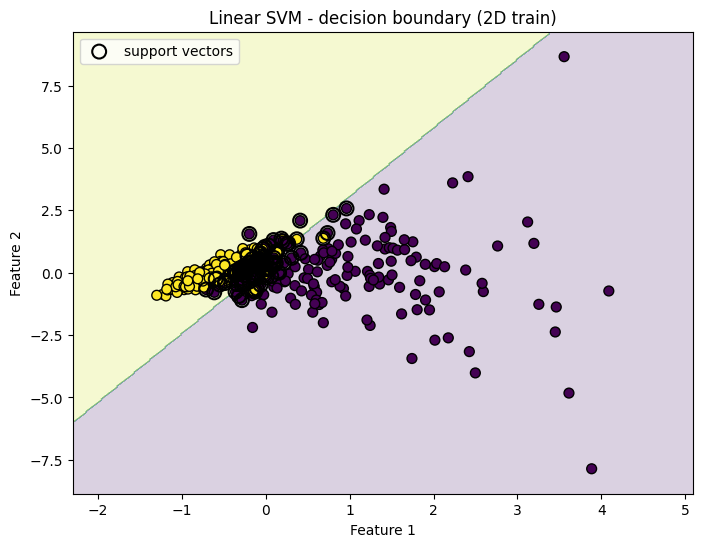

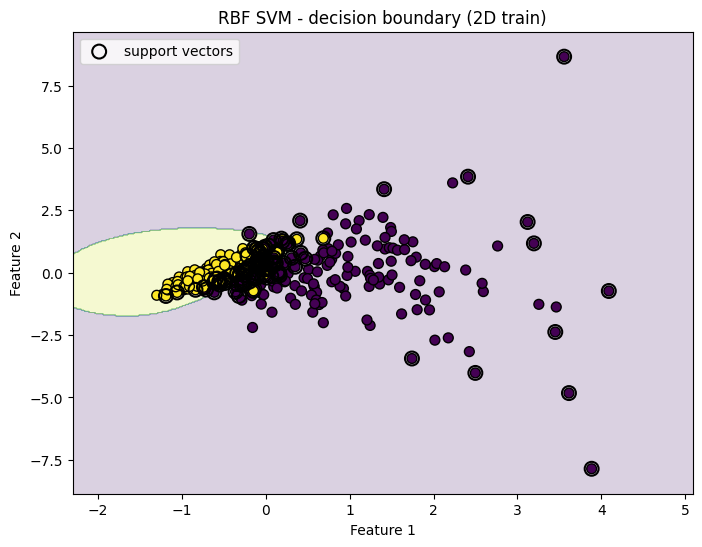

In [9]:
# Cell 7 - plot decision boundary on the 2D data (trained on 2D data)
# Train classifiers on the 2D training split we created earlier (so the boundary is plotted correctly)
clf_lin_2d = SVC(kernel='linear', C=1.0, probability=True, random_state=42)
clf_rbf_2d = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=42)

clf_lin_2d.fit(X_vis_train, y_vis_train)
clf_rbf_2d.fit(X_vis_train, y_vis_train)

plot_decision_boundary(clf_lin_2d, X_vis_train, y_vis_train, title='Linear SVM - decision boundary (2D train)')
plot_decision_boundary(clf_rbf_2d, X_vis_train, y_vis_train, title='RBF SVM - decision boundary (2D train)')


In [10]:
# Cell 8 - grid search
param_grid_linear = {'C': [0.01, 0.1, 1, 10, 100]}
param_grid_rbf = {'C': [0.1, 1, 10, 100], 'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1]}

grid_linear = GridSearchCV(SVC(kernel='linear', probability=True, random_state=42),
                           param_grid_linear, cv=5, scoring='accuracy', n_jobs=-1)
grid_rbf = GridSearchCV(SVC(kernel='rbf', probability=True, random_state=42),
                        param_grid_rbf, cv=5, scoring='accuracy', n_jobs=-1)

print("Running GridSearch for linear SVM...")
grid_linear.fit(X_train_full_scaled, y_train)
print("Best linear params:", grid_linear.best_params_, "Best CV score:", grid_linear.best_score_)

print("\nRunning GridSearch for RBF SVM...")
grid_rbf.fit(X_train_full_scaled, y_train)
print("Best RBF params:", grid_rbf.best_params_, "Best CV score:", grid_rbf.best_score_)


Running GridSearch for linear SVM...
Best linear params: {'C': 0.1} Best CV score: 0.9802197802197803

Running GridSearch for RBF SVM...
Best RBF params: {'C': 10, 'gamma': 0.01} Best CV score: 0.9802197802197803


In [11]:
# Cell 9
best_lin = grid_linear.best_estimator_
best_rbf = grid_rbf.best_estimator_

for name, model in [('Best Linear SVM', best_lin), ('Best RBF SVM', best_rbf)]:
    preds = model.predict(X_test_full_scaled)
    proba = model.predict_proba(X_test_full_scaled)[:,1]
    print(f"--- {name} ---")
    print("Accuracy:", accuracy_score(y_test, preds))
    print(classification_report(y_test, preds))
    cm = confusion_matrix(y_test, preds)
    print("Confusion Matrix:\n", cm)
    cv_scores = cross_val_score(model, np.vstack([X_train_full_scaled, X_test_full_scaled]),
                                np.hstack([y_train, y_test]), cv=5)
    print("Cross-val scores (5-fold) on whole dataset:", np.round(cv_scores, 4))
    print("Mean CV score:", cv_scores.mean())
    print()


--- Best Linear SVM ---
Accuracy: 0.9824561403508771
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        42
           1       0.99      0.99      0.99        72

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114

Confusion Matrix:
 [[41  1]
 [ 1 71]]
Cross-val scores (5-fold) on whole dataset: [0.9737 0.9649 0.9825 0.9737 0.9823]
Mean CV score: 0.9754075454122031

--- Best RBF SVM ---
Accuracy: 0.9824561403508771
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        42
           1       0.99      0.99      0.99        72

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114

Confusion Matrix:
 [[41  1]
 [ 1 71]]
Cross-val scores (5-fold) on whole dataset: [0.9825

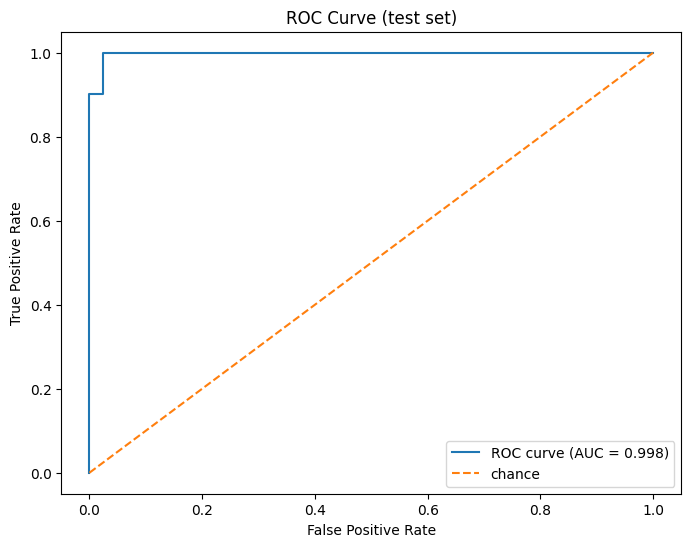

In [12]:
# Cell 10 - ROC for the best of the two (pick by test accuracy or CV)
# Let's pick best_rbf for demonstration
model = best_rbf
y_score = model.predict_proba(X_test_full_scaled)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0,1],[0,1],'--', label='chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (test set)')
plt.legend()
plt.show()


In [13]:
# Cell 11
# Save scaler + best model
joblib.dump(scaler, 'scaler_full.joblib')
joblib.dump(best_rbf, 'svm_best_rbf.joblib')
print("Saved scaler and model to files: scaler_full.joblib, svm_best_rbf.joblib")

# Example load:
loaded_scaler = joblib.load('scaler_full.joblib')
loaded_model = joblib.load('svm_best_rbf.joblib')
# quick sanity check
X_sample = X_test_full_scaled[:5]
print("Loaded model predictions:", loaded_model.predict(X_sample))


Saved scaler and model to files: scaler_full.joblib, svm_best_rbf.joblib
Loaded model predictions: [0 1 0 1 0]
